# Regression for Boundary Value Problems in Solid Mechanics: 
## Comparing 1D Convolutions along the sequence axis with 2D Convolutions along the spatial axes and Recurrent Neural Networks

## Vivek Chavan: 404543

This project was a part of the course work for COmputational Intelligence in Engineering at RWTH Aachen University, Germany,

Finite Element Analysis was performed on a square plate with varying boundary conditions (forces, displacements and so on) and the resuting stresses were monitored.

The aim the project was to develop a machine learning model that acts as a smart element and provides the results instantaneously. These elements can be stacked together to replace traditional CAE assessments. Alexnet was used as a baseline for creating the Convolutional Neural Network and was compared against a Recurrent Neural Network.

These results were then compared against a third model, which was inspired from the Inception model by Google.

The data is a property of RWTH Aachen University and will not be made public.

# Tensorflow gpu check:

In [78]:

import tensorflow as tf 
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name())) 
else: print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


In [79]:

!pip install keras-resnet==0.2.0
!pip install pydot
!pip install pillow
!pip install imageio

# Import

In [80]:
%matplotlib notebook
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPool2D, TimeDistributed, LSTM
import matplotlib

from matplotlib import pyplot as plt
from helpers import DataReader, plot_sample

#Importing all functions from metrics, just in case:
from metrics import mean_absolute_percentage_error, max_relative_error, symmetric_mean_absolute_percentage_error

In [81]:
# Importing additional libraries for ResNet
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, ZeroPadding2D, BatchNormalization, Flatten, Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

from tensorflow.keras.utils import *

from keras.utils import layer_utils
from keras.utils.data_utils import get_file

from IPython.display import SVG
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model

import scipy.misc

import imageio
from matplotlib.pyplot import imshow
%matplotlib inline

import pydot
from keras.utils.vis_utils import model_to_dot

#from resnets_utils import *

from keras.utils import plot_model
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

# 1 Preprocessing

## Data Import

In [82]:
# Change Path
#tfrecord_dir = os.path.join('C:/Users/kuepe/Desktop/Project B CIE/tfrecord/', 'data', 'tfrecord')
#tfrecord_files = glob.glob(os.path.join(tfrecord_dir, '*'))

# PLEASE CHECK THE PATH
tfrecord_dir = os.path.join('D:\ProjectB\data', 'data', 'tfrecord')
#tfrecord_dir = os.path.join(r'C:\Users\Vivek\Desktop\Semester 1\04_Computational_Intelligence_in_Engineering\02_Project_B\Project_B_Data', 'data', 'tfrecord')
tfrecord_files = glob.glob(os.path.join(tfrecord_dir, '*'))
#Data
data_format = 'NSXYF'     # Axes in data: Samples (N), Sequence (S), X-Axis (X), Y-Axis (Y), Features (F)
data_shape = [None, 100, 9, 9, 21]
data_shape_cut = [None, 25, 9, 9, 21]

idx = {'Xi_boundary': [0, 1],
       'Ui': [8, 9],
       'Fi': [16, 17],
       'boundary': [4],
       'Xi': [6, 7],
       'Ui_boundary': [2, 3],
       'body': [5],
       'Si': [10, 11, 12, 13]}
input_features = idx['Ui'] + idx['Si']  
output_features = idx['Fi']


# Hyper parameters - Batch sizes & Learning rates
learning_rate=[0.001]
batch_size_loop=[16]
#learning_rate=[0.0001, 0.001,0.01,0.1]
#batch_size_loop=[8,16,32,64,128]

#data split
tf.random.set_seed(123)
tfrecord_files=tf.random.shuffle(tfrecord_files)

'Data Split is approx. 70-15-15'
train_data, valid_data, test_data = tfrecord_files[:45000], tfrecord_files[45000:55000], tfrecord_files[55000:65000]

In [83]:
train_data.shape

TensorShape([45000])

## Mean and SD:

###  Displacements: Ui
Mean= 0

SD = 0.001

###  Stresses: Si
Mean= 0.011196767

SD = 4.3331237

###  Forces: Fi
Mean= 0

SD = 0.37

### These are now used for hardcoding below.

## Further Preprocessing

In [84]:
#Prepocessing: THIS IS CORRECT PREPROCESSING!!
def preprocess_input(x):
    x,y=tf.split(x, [25,75], 1)
    # mean = tf.reduce_mean(x, axis=(0, 1, 2, 3), keepdims=True)
    mean = tf.convert_to_tensor([0, 0, 0.011196767, 0.011196767, 0.011196767, 0.011196767], np.float32)
    std = tf.convert_to_tensor([0.001, 0.001, 4.3331237, 4.3331237, 4.3331237, 4.3331237], np.float32)
    x = (x - mean) / std
    return x

def preprocess_output(y):
    y,z=tf.split(y, [25,75], 1)
    mean = tf.convert_to_tensor([0, 0], np.float32)
    std = tf.convert_to_tensor([0.37, 0.37], np.float32)
    y = (y - mean) / std
    return y

def preprocess_fun(*batch):
    return (preprocess_input(batch[0]), preprocess_output(batch[1]))


# 2. Plain Convolutional Neural Network


## 1D Convolutions along the sequence axis

In [85]:
history_list=[]
test_loss_list=[]
kernel_size=[2,2]
batch_size_loop=16
learning_rate=0.001

data_reader = DataReader(data_shape, data_format,  batch_size=batch_size_loop, src_type='file',
                         slice_tensors=False, buffer_size=1000,
                         input_features=input_features, output_features=output_features,
                         sample_dtype=tf.float64, cast_dtype=tf.float32)
    
train_dataset = data_reader.generate_batch_dataset(train_data, batch_size_loop)
valid_dataset = data_reader.generate_batch_dataset(valid_data, batch_size_loop)
test_dataset = data_reader.generate_test_dataset(test_data, batch_size_loop)

    
processed_train_dataset = train_dataset.map(preprocess_fun)
processed_valid_dataset = valid_dataset.map(preprocess_fun)
processed_test_dataset = test_dataset.map(preprocess_fun)

tf.keras.backend.clear_session()
def create_ResNet_func_1d(kernel_size,batch_size_loop):
    # Input layer:
    input_shape = list(data_shape_cut[1:-1]) + [len(input_features)]
    inputs = tf.keras.Input(input_shape,batch_size=batch_size_loop)
    x = inputs
    
    # Hidden layers:
    x=TimeDistributed(Flatten())(x)
    
    #1st Convolutional Layer
    x=Conv1D(filters=32, kernel_size=4, padding='same', activation='relu')(x)
    x=MaxPooling1D(pool_size=(2), padding='valid')(x)

    #2nd Conv. Layer
    x = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=(2), padding='valid')(x)

    #3rd Conv. Layer
    x = Conv1D(filters=128,  kernel_size=2, padding='same', activation='relu')(x)


    #1st Dense Layer
    x=Dense(375, activation='relu')(x)

    #2nd Dense Layer
    x=Dense(675, activation='linear')(x)
    x = tf.keras.layers.Reshape((25,9,9,len(output_features)))(x)
    #x = tf.keras.layers.Masking(mask_value=0.0)(x)
    
    # Output layer
    return tf.keras.models.Model(inputs=inputs, outputs=x)


model_ResNet_1D=create_ResNet_func_1d(2,batch_size_loop)

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_ResNet_1D.compile(loss='mae', optimizer=opt)
model_ResNet_1D.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(16, 25, 9, 9, 6)]       0         
_________________________________________________________________
time_distributed (TimeDistri (16, 25, 486)             0         
_________________________________________________________________
conv1d (Conv1D)              (16, 25, 32)              62240     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (16, 12, 32)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (16, 12, 64)              4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (16, 6, 64)               0         
_________________________________________________________________
conv1d_2 (Conv1D)            (16, 6, 128)              16512 

Train for 35.15625 steps, validate for 7.8125 steps
Epoch 1/80
36/35 [==============================] - 3s 92ms/step - loss: 0.2823 - val_loss: 0.2694
Epoch 2/80
36/35 [==============================] - 2s 55ms/step - loss: 0.2734 - val_loss: 0.2705
Epoch 3/80
36/35 [==============================] - 2s 65ms/step - loss: 0.2939 - val_loss: 0.2980
Epoch 4/80
36/35 [==============================] - 2s 64ms/step - loss: 0.2813 - val_loss: 0.2879
Epoch 5/80
36/35 [==============================] - 2s 65ms/step - loss: 0.2821 - val_loss: 0.2899
Epoch 6/80
36/35 [==============================] - 2s 65ms/step - loss: 0.2832 - val_loss: 0.2571
Epoch 7/80
36/35 [==============================] - 2s 65ms/step - loss: 0.2865 - val_loss: 0.2838
Epoch 8/80
36/35 [==============================] - 2s 66ms/step - loss: 0.2918 - val_loss: 0.2859
Epoch 9/80
36/35 [==============================] - 2s 65ms/step - loss: 0.2915 - val_loss: 0.2865
Epoch 10/80
36/35 [==============================] - 2s 6

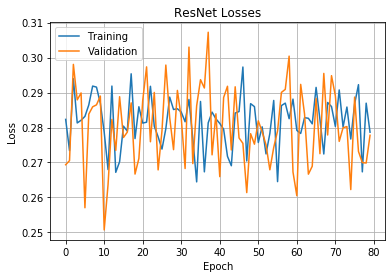

In [86]:
epochs=80
validation_steps= len(valid_data) / (batch_size_loop*epochs)
steps_per_epoch= len(train_data) / (batch_size_loop* epochs)

model_ResNet_1D.compile(optimizer='adam', loss='mae')
history0=model_ResNet_1D.fit(processed_train_dataset,validation_data=processed_valid_dataset,validation_steps=validation_steps,shuffle=True ,steps_per_epoch=steps_per_epoch, epochs=epochs)
history_list.append(history0)

#Testing
test_loss=model_ResNet_1D.evaluate(processed_test_dataset)
test_loss_list.append("Batch= " +str(batch_size_loop)+ "; Learning= " + str(learning_rate)+ "; Test Loss= " + str(test_loss))
model_ResNet_1D.save("ResNet_Model_16_Feb.h5")


print(test_loss_list)

#Vizualisation - traing loss vs validation loss
plt.title('ResNet Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')        
plt.plot(history0.history['loss'])
plt.plot(history0.history['val_loss'])
plt.legend(['Training','Validation'],loc='upper left')
plt.grid(axis='both',which='major')

The 1D convolutions didnt work:
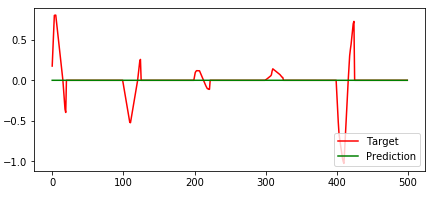

#### Hence we shall purely focus on 2D convolutions from now on

## 2D Convolutions along the spatial axes

In [87]:
history_list=[]
test_loss_list=[]
kernel_size=[2,2]
batch_size_loop=[16]
learning_rate=[0.001]

# for loops - Batch sizes
for i in range(0,len(batch_size_loop)):
    data_reader = DataReader(data_shape, data_format,  batch_size=batch_size_loop[i], src_type='file',
                         slice_tensors=False, buffer_size=1000,
                         input_features=input_features, output_features=output_features,
                         sample_dtype=tf.float64, cast_dtype=tf.float32)
    
    train_dataset = data_reader.generate_batch_dataset(train_data, batch_size_loop[i])
    valid_dataset = data_reader.generate_batch_dataset(valid_data, batch_size_loop[i])
    test_dataset = data_reader.generate_test_dataset(test_data, batch_size_loop[i])

    
    processed_train_dataset = train_dataset.map(preprocess_fun)
    processed_valid_dataset = valid_dataset.map(preprocess_fun)
    processed_test_dataset = test_dataset.map(preprocess_fun)
    


    
    # for loops - Learning rates
    for j in range(0,len(learning_rate)):
        tf.keras.backend.clear_session()
        def create_plainCNN_func(kernel_size,batch_size_loop):
            # Input layer:
            input_shape = list(data_shape_cut[1:-1]) + [len(input_features)]
            inputs = tf.keras.Input(input_shape,batch_size=batch_size_loop)
            x = inputs
            
             
            # Hidden layers:
            #1st Convolutional Layer
            x=tf.keras.layers.TimeDistributed(Conv2D(filters=6, kernel_size=(1,1), padding='same', activation='relu'))(x)
            x = BatchNormalization(axis=2, name='bn_conv1')(x)
            x=tf.keras.layers.TimeDistributed(MaxPool2D(pool_size=(1,1), padding='valid'))(x)
    
            #2nd Conv. Layer
            x = tf.keras.layers.TimeDistributed(Conv2D(filters=8, kernel_size=kernel_size, padding='same', activation='relu'))(x)
            x = BatchNormalization(axis=2, name='bn_conv2')(x)
            x=tf.keras.layers.TimeDistributed(MaxPool2D(pool_size=(2,2), padding='valid'))(x)
            
            
            #3rd Conv. Layer
            x= tf.keras.layers.TimeDistributed(Conv2D(filters=16,  kernel_size=kernel_size, padding='same', activation='relu'))(x)
            x = BatchNormalization(axis=2, name='bn_conv3')(x)
            x=tf.keras.layers.TimeDistributed(MaxPool2D(pool_size=(1,1), padding='valid'))(x)

            #4rd Conv. Layer
            x= tf.keras.layers.TimeDistributed(Conv2D(filters=16,  kernel_size=kernel_size, padding='same', activation='relu'))(x)
            x = BatchNormalization(axis=2, name='bn_conv4')(x)
            x=tf.keras.layers.TimeDistributed(MaxPool2D(pool_size=(1,1), padding='valid'))(x)
            
            #Flattening
            x=TimeDistributed(Flatten())(x)
    

            #1st Dense Layer
            x=TimeDistributed(Dense(240, activation='relu'))(x)
    
            #2nd Dense Layer
            x=TimeDistributed(Dense(162, activation='linear'))(x)
            x = tf.keras.layers.Reshape((25,9,9,len(output_features)))(x)
            #x = tf.keras.layers.Masking(mask_value=0.0)(x)
            
            # Output layer
            return tf.keras.models.Model(inputs=inputs, outputs=x)
        
        #Training
        #validation_steps= len(valid_data) / (batch_size_loop[i]*epochs)
        #steps_per_epoch= len(train_data) / (batch_size_loop[i]* epochs)

        model_plain_CNN=create_plainCNN_func(kernel_size,batch_size_loop[i])
    model_plain_CNN.summary()
        



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(16, 25, 9, 9, 6)]       0         
_________________________________________________________________
time_distributed (TimeDistri (16, 25, 9, 9, 6)         42        
_________________________________________________________________
bn_conv1 (BatchNormalization (16, 25, 9, 9, 6)         36        
_________________________________________________________________
time_distributed_1 (TimeDist (16, 25, 9, 9, 6)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (16, 25, 9, 9, 8)         200       
_________________________________________________________________
bn_conv2 (BatchNormalization (16, 25, 9, 9, 8)         36        
_________________________________________________________________
time_distributed_3 (TimeDist (16, 25, 4, 4, 8)         0     

In [88]:
epochs=80
validation_steps= len(valid_data) / (batch_size_loop[i]*epochs)
steps_per_epoch= len(train_data) / (batch_size_loop[i]* epochs)

model_plain_CNN.compile(optimizer='adam', loss='mae')
history_model_plain_CNN=model_plain_CNN.fit(processed_train_dataset,validation_data=processed_valid_dataset,validation_steps=validation_steps,shuffle=True ,steps_per_epoch=steps_per_epoch, epochs=epochs)
history_list.append(history_model_plain_CNN)

#Testing
test_loss=model_plain_CNN.evaluate(processed_test_dataset)
test_loss_list.append("Batch= " +str(batch_size_loop[i])+ "; Learning= " + str(learning_rate[j])+ "; Test Loss= " + str(test_loss))
model_plain_CNN.save("ResNet_Model_16_Feb" + str(i) + ".h5")


print(test_loss_list)

#Vizualisation - traing loss vs validation loss
plt.title('Plain_CNN_Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')        
plt.plot(history_model_plain_CNN.history['loss'])
plt.plot(history_model_plain_CNN.history['val_loss'])
plt.legend(['Training','Validation'],loc='upper left')
plt.grid(axis='both',which='major')
plt.savefig('Fig_ResNetFinal_B' + str(batch_size_loop[i]) + "l" + str(learning_rate[j]) + ".png")        
plt.clf()

Train for 35.15625 steps, validate for 7.8125 steps
Epoch 1/80
36/35 [==============================] - 4s 119ms/step - loss: 0.3745 - val_loss: 0.2705
Epoch 2/80
36/35 [==============================] - 2s 58ms/step - loss: 0.2552 - val_loss: 0.2603
Epoch 3/80
36/35 [==============================] - 2s 68ms/step - loss: 0.2333 - val_loss: 0.2584
Epoch 4/80
36/35 [==============================] - 2s 68ms/step - loss: 0.2323 - val_loss: 0.2403
Epoch 5/80
36/35 [==============================] - 2s 67ms/step - loss: 0.2246 - val_loss: 0.2146
Epoch 6/80
36/35 [==============================] - 2s 68ms/step - loss: 0.2120 - val_loss: 0.2024
Epoch 7/80
36/35 [==============================] - 2s 66ms/step - loss: 0.2050 - val_loss: 0.1766
Epoch 8/80
36/35 [==============================] - 2s 68ms/step - loss: 0.1963 - val_loss: 0.1549
Epoch 9/80
36/35 [==============================] - 2s 67ms/step - loss: 0.1713 - val_loss: 0.1730
Epoch 10/80
36/35 [==============================] - 2s 

<Figure size 432x288 with 0 Axes>

# 4 Projekt: Residual Network (with Skip Connections)

In [89]:
kernel_size=[2,2]
batch_size_loop=[16]
epochs=80

# for loops - Batch sizes
for i in range(0,len(batch_size_loop)):
    data_reader = DataReader(data_shape, data_format,  batch_size=batch_size_loop[i], src_type='file',
                         slice_tensors=False, buffer_size=1000,
                         input_features=input_features, output_features=output_features,
                         sample_dtype=tf.float64, cast_dtype=tf.float32)
    
    train_dataset = data_reader.generate_batch_dataset(train_data, batch_size_loop[i])
    valid_dataset = data_reader.generate_batch_dataset(valid_data, batch_size_loop[i])
    test_dataset = data_reader.generate_test_dataset(test_data, batch_size_loop[i])

    
    processed_train_dataset = train_dataset.map(preprocess_fun)
    processed_valid_dataset = valid_dataset.map(preprocess_fun)
    processed_test_dataset = test_dataset.map(preprocess_fun)
    


    
    # for loops - Learning rates
    for j in range(0,len(learning_rate)):
        tf.keras.backend.clear_session()
        def create_ResNET_2D(kernel_size,batch_size_loop):
            # Input layer:
            input_shape = list(data_shape_cut[1:-1]) + [len(input_features)]
            inputs = tf.keras.Input(input_shape,batch_size=batch_size_loop)
            x = inputs
            
            x_short=x
            
            # Hidden layers:
            #1st Convolutional Layer
            x=tf.keras.layers.TimeDistributed(Conv2D(filters=6, kernel_size=(1,1), padding='same', activation='relu'))(x)
            x = BatchNormalization(axis=2, name='bn_conv1')(x)
            x=tf.keras.layers.TimeDistributed(MaxPool2D(pool_size=(1,1), padding='valid'))(x)
    
            #2nd Conv. Layer
            x = tf.keras.layers.TimeDistributed(Conv2D(filters=8, kernel_size=kernel_size, padding='same', activation='relu'))(Add()([x, x_short]))
            x = BatchNormalization(axis=2, name='bn_conv2')(x)
            x=tf.keras.layers.TimeDistributed(MaxPool2D(pool_size=(2,2), padding='valid'))(x)
            
            x_short2=x

            #3rd Conv. Layer
            x= tf.keras.layers.TimeDistributed(Conv2D(filters=8,  kernel_size=kernel_size, padding='same', activation='relu'))(x)
            x = BatchNormalization(axis=2, name='bn_conv3')(x)
            x=tf.keras.layers.TimeDistributed(MaxPool2D(pool_size=(1,1), padding='valid'))(x)
            
            #4rd Conv. Layer
            x= tf.keras.layers.TimeDistributed(Conv2D(filters=16,  kernel_size=kernel_size, padding='same', activation='relu'))(Add()([x, x_short2]))
            x = BatchNormalization(axis=2, name='bn_conv4')(x)
            x=tf.keras.layers.TimeDistributed(MaxPool2D(pool_size=(2,2), padding='valid'))(x)
            
            #Flattening
            x=TimeDistributed(Flatten())(x)
    

            #1st Dense Layer
            x=TimeDistributed(Dense(240, activation='relu'))(x)
    
            #2nd Dense Layer
            x=TimeDistributed(Dense(162, activation='linear'))(x)
            x = tf.keras.layers.Reshape((25,9,9,len(output_features)))(x)
            #x = tf.keras.layers.Masking(mask_value=0.0)(x)
            
            # Output layer
            return tf.keras.models.Model(inputs=inputs, outputs=x)
        
        #Training
        #validation_steps= len(valid_data) / (batch_size_loop[i]*epochs)
        #steps_per_epoch= len(train_data) / (batch_size_loop[i]* epochs)

        model_ResNet_CNN=create_ResNET_2D(kernel_size,batch_size_loop[i])

        #opt = tf.keras.optimizers.Adam(learning_rate=learning_rate[j])
        #model_plain_CNN.compile(loss='mae', optimizer=opt)




In [90]:
model_ResNet_CNN.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(16, 25, 9, 9, 6)]  0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (16, 25, 9, 9, 6)    42          input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (16, 25, 9, 9, 6)    36          time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (16, 25, 9, 9, 6)    0           bn_conv1[0][0]                   
______________________________________________________________________________________________

In [91]:
validation_steps= len(valid_data) / (batch_size_loop[i]*epochs)
steps_per_epoch= len(train_data) / (batch_size_loop[i]* epochs)

model_ResNet_CNN.compile(optimizer='adam', loss='mae')
history_model_ResNet_CNN=model_ResNet_CNN.fit(processed_train_dataset,validation_data=processed_valid_dataset,validation_steps=validation_steps,shuffle=True ,steps_per_epoch=steps_per_epoch, epochs=epochs)
history_list.append(history_model_ResNet_CNN)

#Testing
test_loss=model_ResNet_CNN.evaluate(processed_test_dataset)
test_loss_list.append("Batch= " +str(batch_size_loop[i])+ "; Learning= " + str(learning_rate[j])+ "; Test Loss= " + str(test_loss))
model_ResNet_CNN.save("model_ResNet_CNN" + str(i) + ".h5")


print(test_loss_list)

#Vizualisation - traing loss vs validation loss
plt.title('ResNet Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')        
plt.plot(history_model_ResNet_CNN.history['loss'])
plt.plot(history_model_ResNet_CNN.history['val_loss'])
plt.legend(['Training','Validation'],loc='upper left')
plt.grid(axis='both',which='major')
plt.savefig('Fig_ResNetFinal_B' + str(batch_size_loop[i]) + "l" + str(learning_rate[j]) + ".png")        
plt.clf()

Train for 35.15625 steps, validate for 7.8125 steps
Epoch 1/80
36/35 [==============================] - 4s 119ms/step - loss: 0.3659 - val_loss: 0.2928
Epoch 2/80
36/35 [==============================] - 2s 56ms/step - loss: 0.2694 - val_loss: 0.2565
Epoch 3/80
36/35 [==============================] - 2s 66ms/step - loss: 0.2425 - val_loss: 0.2624
Epoch 4/80
36/35 [==============================] - 2s 65ms/step - loss: 0.2432 - val_loss: 0.2332
Epoch 5/80
36/35 [==============================] - 2s 65ms/step - loss: 0.2106 - val_loss: 0.2008
Epoch 6/80
36/35 [==============================] - 2s 66ms/step - loss: 0.1990 - val_loss: 0.1851
Epoch 7/80
36/35 [==============================] - 2s 66ms/step - loss: 0.1937 - val_loss: 0.1630
Epoch 8/80
36/35 [==============================] - 2s 65ms/step - loss: 0.1851 - val_loss: 0.1630
Epoch 9/80
36/35 [==============================] - 2s 65ms/step - loss: 0.1757 - val_loss: 0.1728
Epoch 10/80
36/35 [==============================] - 2s 

<Figure size 432x288 with 0 Axes>

# 5. Reference Network: Recurrent Neural Network

### LSTM

In [92]:
epochs=80

# for loops - Batch sizes
for i in range(0,len(batch_size_loop)):
    data_reader = DataReader(data_shape, data_format,  batch_size=batch_size_loop[i], src_type='file',
                         slice_tensors=False, buffer_size=1000,
                         input_features=input_features, output_features=output_features,
                         sample_dtype=tf.float64, cast_dtype=tf.float32)
    
    train_dataset = data_reader.generate_batch_dataset(train_data, batch_size_loop[i])
    valid_dataset = data_reader.generate_batch_dataset(valid_data, batch_size_loop[i])
    test_dataset = data_reader.generate_test_dataset(test_data, batch_size_loop[i])
    processed_train_dataset = train_dataset.map(preprocess_fun)
    processed_valid_dataset = valid_dataset.map(preprocess_fun)
    processed_test_dataset = test_dataset.map(preprocess_fun)
    
    # for loops - Learning rates
    for j in range(0,len(learning_rate)):
        tf.keras.backend.clear_session()
        def create_RecNET(batch_size):
            input_shape = list(data_shape_cut[1:-1]) + [len(input_features)]
            
            # Input layer
            inputs = tf.keras.Input(input_shape,batch_size=batch_size)
            x = inputs
            
            # Hidden layers:
            # Flatten layer - flatten 5d tensor into 3d tensor which is the required input for lstm layer
            x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)  
            #x = SequenceMasking(mask_value=0.)(x)
    
            # 1st LSTM layer
            x = tf.keras.layers.LSTM(324, activation='tanh', return_sequences=True, dropout=0.1)(x)
   
            # 2nd LSTM layer
            x = tf.keras.layers.LSTM(216, activation='tanh', return_sequences=True, dropout=0.1)(x)
        
            # 3rd LSTM layer
            #x = tf.keras.layers.LSTM(216, activation='tanh', return_sequences=True, dropout=0.1)(x)
   

            #x=tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(334, activation='relu'))(x)
            #x= Dropout(0.2)(x)

            # Dense layer - linear activation - make sure all output between +ve and -ve
            x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(162, activation='linear'))(x)
            # Reshape layer - reshape 3d tensor back to 5d tensor
            x = tf.keras.layers.TimeDistributed(tf.keras.layers.Reshape((9,9,len(output_features))))(x)
            #x = tf.keras.layers.Masking(mask_value=0.)(x)
            
            # Output layers
            return tf.keras.models.Model(inputs=inputs, outputs=x)
        
        # Training
        validation_steps= len(valid_data) / (batch_size_loop[i]*epochs)
        steps_per_epoch= len(train_data) / (batch_size_loop[i]* epochs)

        model_RNN_LSTM=create_RecNET(batch_size_loop[i])

        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate[j])
        model_RNN_LSTM.compile(loss='mae', optimizer=opt)
        model_RNN_LSTM.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(16, 25, 9, 9, 6)]       0         
_________________________________________________________________
time_distributed (TimeDistri (16, 25, 486)             0         
_________________________________________________________________
lstm (LSTM)                  (16, 25, 324)             1051056   
_________________________________________________________________
lstm_1 (LSTM)                (16, 25, 216)             467424    
_________________________________________________________________
time_distributed_1 (TimeDist (16, 25, 162)             35154     
_________________________________________________________________
time_distributed_2 (TimeDist (16, 25, 9, 9, 2)         0         
Total params: 1,553,634
Trainable params: 1,553,634
Non-trainable params: 0
___________________________________________________

In [93]:
        model_RNN_LSTM.compile(optimizer='adam', loss='mae')
        history_model_RNN_LSTM=model_RNN_LSTM.fit(processed_train_dataset,validation_data=processed_valid_dataset,validation_steps=validation_steps,shuffle=True ,steps_per_epoch=steps_per_epoch, epochs=epochs)
        history_list.append(history_model_RNN_LSTM)
        
        #Testing
        test_loss=model_RNN_LSTM.evaluate(processed_test_dataset)
        test_loss_list.append("Batch= " +str(batch_size_loop[i])+ "; Learning= " + str(learning_rate[j])+ "; Test Loss= " + str(test_loss))
        model_RNN_LSTM.save("model_RNN_LSTM" + str(i) + ".h5")
        
        #Vizualisation - traing loss vs validation loss
        plt.title('RecNet Losses')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')        
        plt.plot(history_model_RNN_LSTM.history['loss'])
        plt.plot(history_model_RNN_LSTM.history['val_loss'])
        plt.legend(['Training','Validation'],loc='upper left')
        plt.grid(axis='both',which='major')
        plt.savefig('Fig_RecFinal_B' + str(batch_size_loop[i]) + "l" + str(learning_rate[j]) + ".png")        
        plt.clf()
        
print(test_loss_list)

Train for 35.15625 steps, validate for 7.8125 steps
Epoch 1/80
36/35 [==============================] - 6s 172ms/step - loss: 0.2838 - val_loss: 0.2263
Epoch 2/80
36/35 [==============================] - 2s 59ms/step - loss: 0.1854 - val_loss: 0.1302
Epoch 3/80
36/35 [==============================] - 2s 68ms/step - loss: 0.1337 - val_loss: 0.1185
Epoch 4/80
36/35 [==============================] - 2s 68ms/step - loss: 0.1178 - val_loss: 0.1013
Epoch 5/80
36/35 [==============================] - 3s 71ms/step - loss: 0.0978 - val_loss: 0.0924
Epoch 6/80
36/35 [==============================] - 2s 68ms/step - loss: 0.1002 - val_loss: 0.0934
Epoch 7/80
36/35 [==============================] - 2s 69ms/step - loss: 0.0953 - val_loss: 0.0918
Epoch 8/80
36/35 [==============================] - 2s 68ms/step - loss: 0.0938 - val_loss: 0.0727
Epoch 9/80
36/35 [==============================] - 3s 71ms/step - loss: 0.0840 - val_loss: 0.0685
Epoch 10/80
36/35 [==============================] - 2s 

<Figure size 432x288 with 0 Axes>

# 6 Postprocessing

## Create a Numpy array for Test Dataset

In [94]:
#These functions will be used for generating a target set

def dummy_fun_ip(x):
    x,y=tf.split(x, [25,75], 1)
    mean = tf.convert_to_tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    std = tf.convert_to_tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    x=(x-mean)/std
    return x

def dummy_fun_op(x):
    x,y=tf.split(x, [25,75], 1)
    mean = tf.convert_to_tensor([0.0, 0.0])
    std = tf.convert_to_tensor([1.0, 1.0])
    x=(x-mean)/std
    return x    

def preprocess_tf(*batch):
    return (dummy_fun_ip(batch[0]), dummy_fun_op(batch[1]))

processed_test_dataset2 = test_dataset.map(preprocess_tf)

nn_target = [batch[1] for batch in processed_test_dataset2]
target = zip(*nn_target)
target = [np.concatenate(o, axis=0) for o in target]

# Get Target set maskm for calculating SMAPPE:
target_mask=tf.abs(target)
target_mask= tf.cast(tf.sign(target), tf.bool)

target2=tf.boolean_mask(target, target_mask)
    
np.shape(target)

(16, 15625, 9, 9, 2)

## Data postprocessing

In [95]:
def postprocess_output(y_):
    mean = tf.convert_to_tensor([0, 0], np.float32)
    std = tf.convert_to_tensor([0.37, 0.37], np.float32)
    y_ = (y_ * std) + mean
    return y_

#Creating a similar postprocessing function
def postprocess_fun(*batch):
    return (postprocess_output(batch[0]))

##  SMAPE Calculation: Plain Convolutional Neural Network

In [96]:
nn_output0 = [model_plain_CNN.predict(batch) for batch in processed_test_dataset]
output0 = [postprocess_fun(nno) for nno in nn_output0]
output0 = zip(*output0)
output0 = [np.concatenate(o, axis=0) for o in output0]
np.shape(output0)

#Symmetric Mean Absolute Percentage Error (SMAPE)
output20=tf.boolean_mask(output0, target_mask)

smape0 = symmetric_mean_absolute_percentage_error(
target2, output20, reduction_axes=None, norm_mode='range')

print('The SMAPE for AlexNet is: ')
print(smape0)

The SMAPE for AlexNet is: 
0.1371258171275258


##  SMAPE Calculation: LSTM Recurrent Neural Network

In [97]:
nn_output1 = [model_RNN_LSTM.predict(batch) for batch in processed_test_dataset]
output1 = [postprocess_fun(nno) for nno in nn_output1]
output1 = zip(*output1)
output1 = [np.concatenate(o, axis=0) for o in output1]
np.shape(output1)

#Symmetric Mean Absolute Percentage Error (SMAPE)
output21=tf.boolean_mask(output1, target_mask)

smape1 = symmetric_mean_absolute_percentage_error(
target2, output21, reduction_axes=None, norm_mode='range')

print('The SMAPE of LSTM is: ')
print(smape1)

The SMAPE of LSTM is: 
0.08705375948920846


## SMAPE Calculation: Residual Neural Network (Target)

In [99]:
nn_output2 = [model_ResNet_CNN.predict(batch) for batch in processed_test_dataset]
output2 = [postprocess_fun(nno) for nno in nn_output2]
output2 = zip(*output2)
output2 = [np.concatenate(o, axis=0) for o in output2]
np.shape(output2)

#Symmetric Mean Absolute Percentage Error (SMAPE)
output22=tf.boolean_mask(output2, target_mask)

smape2 = symmetric_mean_absolute_percentage_error(
target2, output22, reduction_axes=None, norm_mode='range')

print('The SMAPE of the Residual Network is: ')
print(smape2)

The SMAPE of the Residual Network is: 
0.12944109039381146


## Visualization of Results: Training and Validation Losses

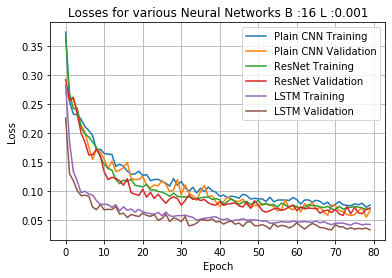

In [100]:
#plotting all the losses

plt.title('Losses for various Neural Networks B :' + str(batch_size_loop[i]) + " L :" + str(learning_rate[j]))
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.plot(history_model_plain_CNN.history['loss'],label='Plain CNN')
plt.plot(history_model_plain_CNN.history['val_loss'],label='Plain CNN')

plt.plot(history_model_ResNet_CNN.history['loss'],label='ResNet')
plt.plot(history_model_ResNet_CNN.history['val_loss'],label='ResNet')

plt.plot(history_model_RNN_LSTM.history['loss'],label='LSTM')
plt.plot(history_model_RNN_LSTM.history['val_loss'],label='LSTM')

plt.legend(['Plain CNN Training','Plain CNN Validation','ResNet Training','ResNet Validation','LSTM Training','LSTM Validation'],loc='upper right')
plt.grid(axis='both',which='major')
plt.savefig('Fig_comp' + str(batch_size_loop[i]) + "l" + str(learning_rate[j]) + ".png") 
plt.show()

##  Visualization of Results: Force at a given point along different sequences and samples

(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)


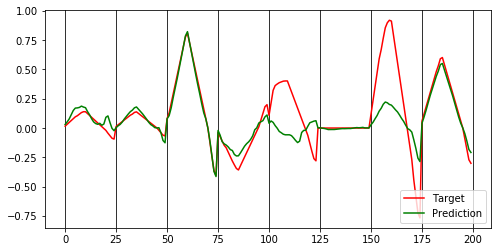

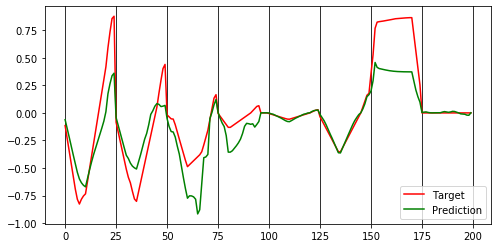

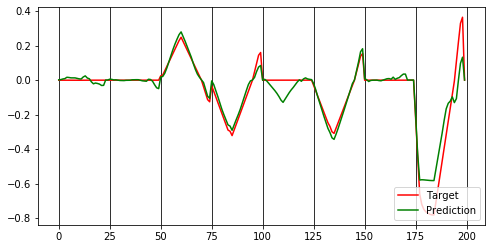

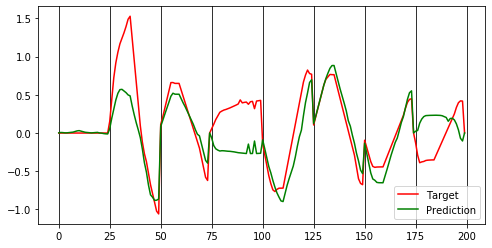

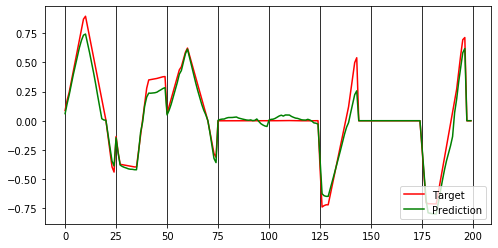

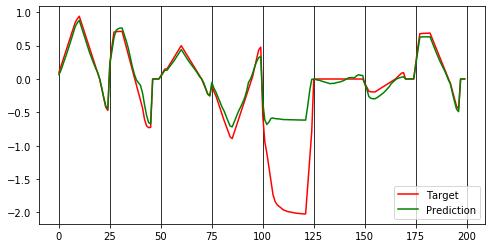

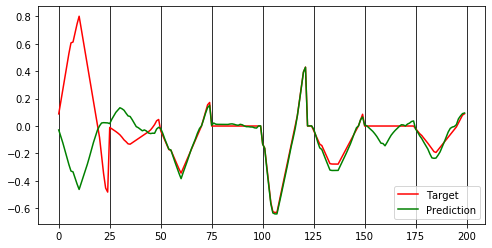

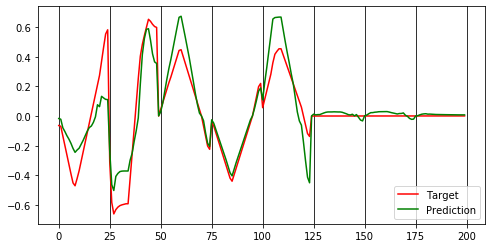

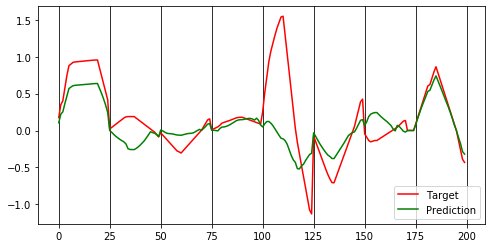

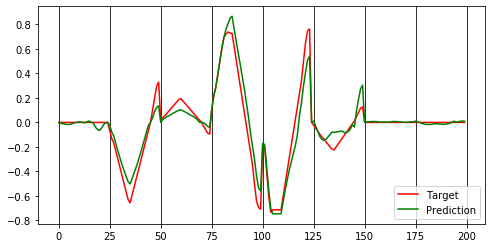

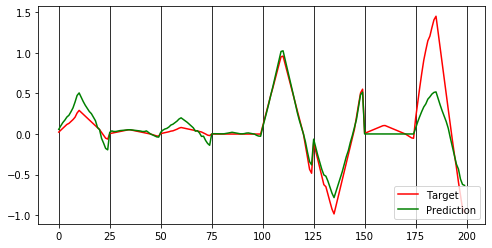

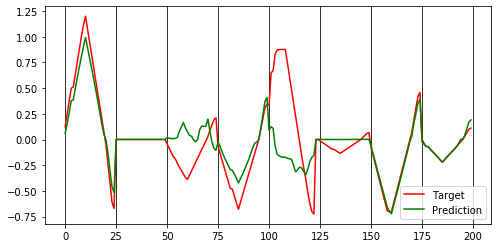

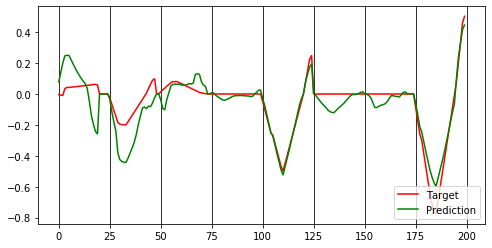

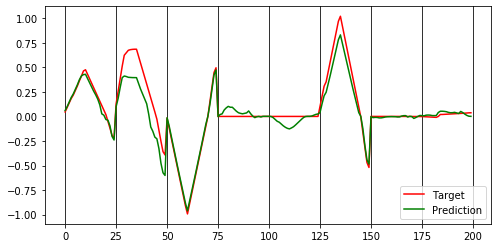

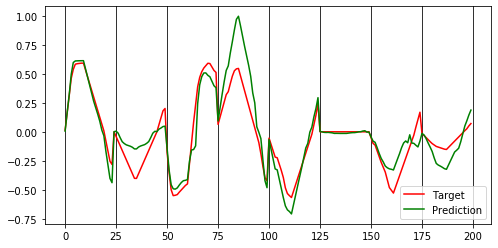

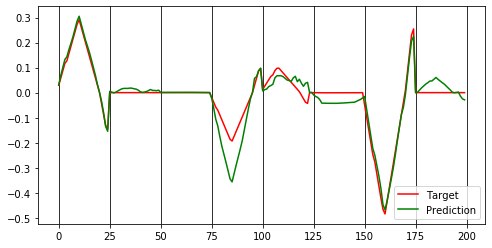

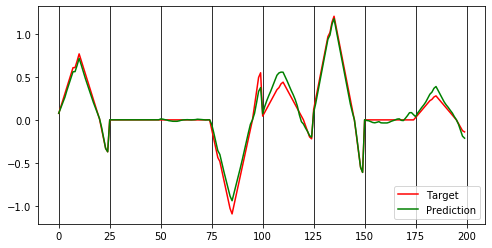

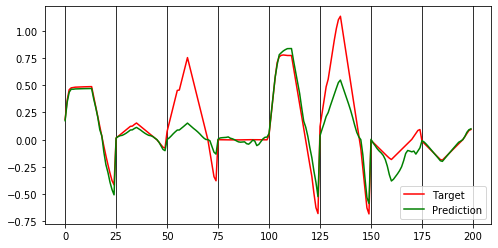

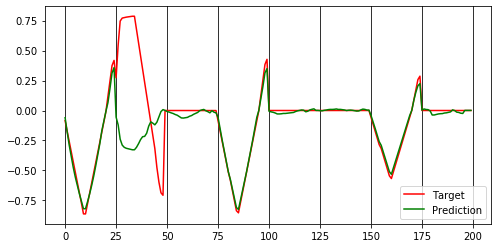

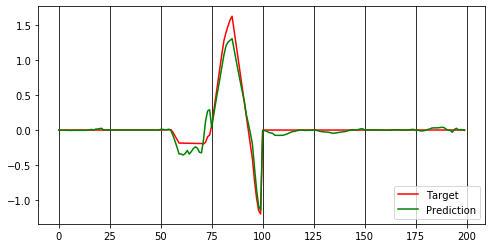

In [101]:
# Prediction vs Target

for iter in range(20):
    
    sample = target[3]
    tmp2 = sample[0+(500*iter):200+(500*iter), 0, 0, 0]
    print(tmp2.shape)
    fig = plt.figure(figsize=(8,4))
    plt.plot(tmp2, 'r')

    sample3 = output2[3]
    tmp3 = sample3[0+(500*iter):200+(500*iter), 0, 0, 0]
    plt.plot(tmp3, 'g')
    plt.legend(['Target','Prediction'],loc='lower right')
    plt.grid(color='black', which='both', axis='x', linestyle='solid')
    #plt.savefig('GRU_Seq'+ str(iter)+'.png') 